In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [30]:
data = pd.read_csv('data/clean/Breyer.csv')
X = data['cleanText'].fillna(' ').to_numpy()
y = data['vote'].to_numpy()

In [31]:
model = make_pipeline(TfidfVectorizer(), 
                      SMOTE(), 
                      RandomForestClassifier())

params = {'randomforestclassifier__max_depth': [3, None],
          'randomforestclassifier__max_features': ['sqrt', 'log2', None],
          'randomforestclassifier__min_samples_split': [2, 4],
          'randomforestclassifier__min_samples_leaf': [1, 2, 3],
          'randomforestclassifier__bootstrap': [True, False],
          'randomforestclassifier__n_estimators': [10, 50, 75, 100, 150],
          'randomforestclassifier__criterion': ['gini', 'entropy'],
          'randomforestclassifier__random_state': [1]}

grid = GridSearchCV(model, 
                    params, 
                    n_jobs=-1,
                    verbose=True,
                    scoring='recall')
grid.fit(X, y)

print("best parameters:", grid.best_params_)

best_rf_model = grid.best_estimator_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 56.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 69.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 121.4min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 162.0min finished


best parameters: {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__random_state': 1}


In [37]:
best_parameters = {'randomforestclassifier__bootstrap': False, 
                  'randomforestclassifier__criterion': 'gini', 
                  'randomforestclassifier__max_depth': None, 
                  'randomforestclassifier__max_features': None, 
                  'randomforestclassifier__min_samples_leaf': 3, 
                  'randomforestclassifier__min_samples_split': 2, 
                  'randomforestclassifier__n_estimators': 100, 
                  'randomforestclassifier__random_state': 1}

In [47]:
def balance_train_data(X, y, method=None):
    uniq, cts = np.unique(y, return_counts=True)
    
    if method == None:
        return X, y
    
    elif method == 'undersampling':
        rus = RandomUnderSampler()
        X_train, y_train = rus.fit_resample(X, y)
        return X_train, y_train
    
    elif method == 'oversampling':    
        ros = RandomOverSampler()
        X_train, y_train = ros.fit_resample(X, y)
        return X_train, y_train
    
    elif method == 'smote':
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(X, y)
        return X_train, y_train
    
    elif method == 'both':
        smote = SMOTE(sampling_strategy=0.75)
        under = RandomUnderSampler(sampling_strategy=1)
        X_train, y_train = smote.fit_resample(X, y)
        X_train, y_train = under.fit_resample(X_train, y_train)
        return X_train, y_train

    else:
        print('Incorrect balance method')
        return

def plot_cross_val(models, data, ax, sampling_method):

    X = data['cleanText'].to_numpy()
    y = data['vote'].to_numpy()

    kf = KFold(n_splits=5, shuffle=True)

    precisions = [[], []] 
    recalls = [[], []]
    
    for train, test in kf.split(X):
        X_test, y_test = X[test], y[test]
        X_train, y_train = X[train], y[train]
        
        tfidf = TfidfVectorizer()
        train_vectors = tfidf.fit_transform(X_train)
        test_vectors = tfidf.transform(X_test)  
        
        train_vectors, y_train = balance_train_data(train_vectors, y_train, method=sampling_method)
         
        for i, model in enumerate(models):
            model.fit(train_vectors, y_train)
            y_pred = model.predict(test_vectors)
            
            precisions[i].append(precision_score(y_test, y_pred))
            recalls[i].append(recall_score(y_test, y_pred))
    
    x = range(0, 5)
    colormap = {0 : 'r',
                1 : 'b',
                2 : 'g'}
    
    
    names = ['Default RF', 'Optimized RF']
    for i in range(len(models)):
        ax.plot(x, precisions[i], c=colormap[i], 
                linewidth=1, linestyle='-',
                label='%s Precision' % names[i])
        ax.plot(x, recalls[i], c=colormap[i], 
                linewidth=1, linestyle='--',
                label='%s Recall' % names[i])

(-0.05, 1)

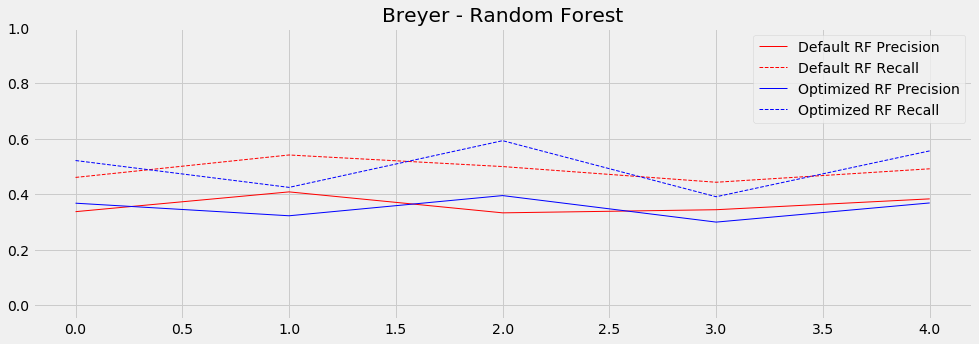

In [48]:
default_rf = RandomForestClassifier()
best_rf = RandomForestClassifier(bootstrap=False, criterion='gini',
                                max_depth=None, max_features=None, 
                                min_samples_leaf=3, min_samples_split=2, 
                                n_estimators=100)

fig, ax = plt.subplots(figsize=(15, 5))
models = [default_rf, best_rf]

data = pd.read_csv('data/clean/Breyer.csv')
data['cleanText'] = data['cleanText'].fillna(' ')
plot_cross_val(models, data, ax, 'undersampling')
ax.set_title('Breyer - Random Forest')
ax.legend()
ax.set_ylim(-0.05, 1)




In [49]:
data = pd.read_csv('data/clean/Breyer.csv')
X = data['cleanText'].fillna(' ').to_numpy()
y = data['vote'].to_numpy()

In [50]:
model = make_pipeline(TfidfVectorizer(), 
                      SMOTE(), 
                      GradientBoostingClassifier())

params = {'gradientboostingclassifier__max_depth': [3, None],
          'gradientboostingclassifier__max_features': ['sqrt', 'log2', None],
          'gradientboostingclassifier__min_samples_split': [2, 3, 4],
          'gradientboostingclassifier__min_samples_leaf': [1, 2, 3],
          'gradientboostingclassifier__n_estimators': [10, 50, 75, 100, 150],
          'gradientboostingclassifier__loss': ['deviance', 'exponential'],
          'gradientboostingclassifier__random_state': [1]}

grid = GridSearchCV(model, 
                    params, 
                    n_jobs=-1,
                    verbose=True,
                    scoring='recall')
grid.fit(X, y)

print("best parameters:", grid.best_params_)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 51.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 101.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 114.7min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 188.4min finished


best parameters: {'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__max_depth': None, 'gradientboostingclassifier__max_features': None, 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 4, 'gradientboostingclassifier__n_estimators': 150, 'gradientboostingclassifier__random_state': 1}


In [ ]:
best_parameters: {'gradientboostingclassifier__loss': 'exponential', 
                  'gradientboostingclassifier__max_depth': None, 
                  'gradientboostingclassifier__max_features': None, 
                  'gradientboostingclassifier__min_samples_leaf': 1, 
                  'gradientboostingclassifier__min_samples_split': 4, 
                  'gradientboostingclassifier__n_estimators': 150, 
                  'gradientboostingclassifier__random_state': 1}

(-0.05, 1)

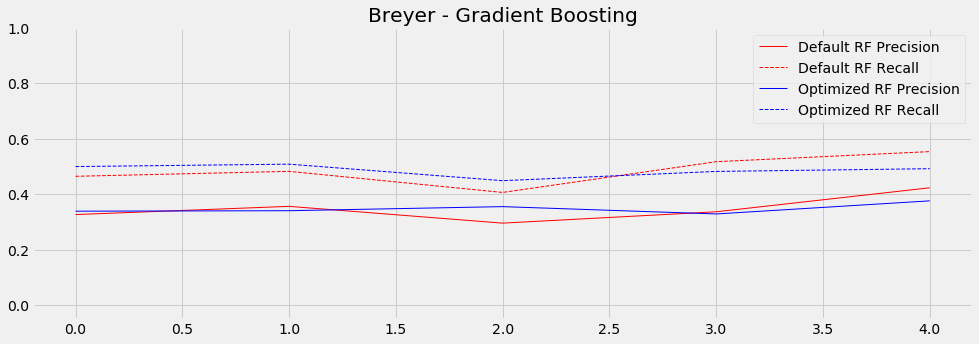

In [51]:
default_gb = GradientBoostingClassifier()
best_gb = GradientBoostingClassifier(max_depth=None, max_features=None, 
                                min_samples_leaf=1, min_samples_split=4, 
                                n_estimators=150, learning_rate=0.1)

fig, ax = plt.subplots(figsize=(15, 5))
models = [default_gb, best_gb]

data = pd.read_csv('data/clean/Breyer.csv')
data['cleanText'] = data['cleanText'].fillna(' ')
plot_cross_val(models, data, ax, 'undersampling')
ax.set_title('Breyer - Gradient Boosting')
ax.legend()
ax.set_ylim(-0.05, 1)

